In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style = "whitegrid",font_scale=1.4)
from scipy.spatial.distance import pdist, squareform



In [2]:
data_path = os.path.join(os.path.expanduser('~'), 'Library/CloudStorage/Box-Box', 'COVID-19 Adolphs Lab','PreProcessed_Data')
selResp_path = os.path.join(os.path.expanduser('~'), 'Library/CloudStorage/Box-Box', 'COVID-19 Adolphs Lab','core_analysis','self_response')
out_dir = os.path.expanduser('~/Library/CloudStorage/Box-Box/COVID-19 Adolphs Lab/core_analysis/external_selfResp_combined')
fig_dir = os.path.expanduser('~/Library/CloudStorage/Box-Box/COVID-19 Adolphs Lab/core_analysis/figures')
core_data_path = os.path.join(os.path.expanduser('~'), 'Library/CloudStorage/Box-Box', 'COVID-19 Adolphs Lab','core_analysis','processed_data')

data_file = 'Wave1-18_A-N_release.csv'
data = pd.read_csv(os.path.join(data_path, data_file), low_memory=False, na_values='NaN', dtype = str)
# include only full prlfc waves 
data = data.loc[data.wave.isin(['1', '2', '3', '4', '5', '6', '7', '8', '9',
                                '10', '11', '12', '13', '14', '15', '16', '17']), :]

# add week numbers for more accurate temproal representation of waves
wave_to_week = pd.read_csv(os.path.join(selResp_path, 'wave_to_week.csv'),dtype = str)
wave_dict = {wave_to_week.loc[i, 'wave']:wave_to_week.loc[i, 'wave_week'] for i in wave_to_week.index}
data['week'] = data['wave'].copy() 
data.week.replace(wave_dict, inplace = True)
data = data.astype({'wave': 'float', 'week': 'float'})



# Maximum Variation Sampling

In [3]:
###########################################################################################################################
# code from Yanting Han: https://github.com/adolphslab/CovidDynamic_dataRelease/blob/main/figures-tables/TempTrends_ExmplVars%20/IDforplot.py
# Farthest point sampling
def calc_distances(p0, points):
    return np.sqrt(((p0 - points)**2.).sum(axis=1))

def farthest_points(pts, pt_labels, K,ii):
    ndims = pts.shape[1] #5 dims
    farthest_pts = np.zeros((K, ndims)) # specify format for wanted points, 5/10 people*5 dim
    farthest_pts[0] = pts[ii]  
    farthest_pts_labs = []
    farthest_pts_labs.append(pt_labels[ii]) # append label 
    distances = calc_distances(farthest_pts[0], pts) # calculate dist for this subject with all other ones

    for ij in range(1, K):
        farthest_pts[ij] = pts[np.argmax(distances)] #returns the index of the subject with the furthest dist
        farthest_pts_labs.append(pt_labels[np.argmax(distances)])
        distances = np.minimum(distances, calc_distances(farthest_pts[ij], pts))
        # for the rest of the points, update the distance to be the min to the already chosen ones
    return farthest_pts, farthest_pts_labs

# maximum variation sampling (eucl.-dist)
def max_var_sampling(value_array, id_lables, K):
    all_sols_dists = []
    all_sols_feats = []
    all_sols_names = []
    for iter_ii in range(value_array.shape[0]):
        solution_set, solution_labels = farthest_points(value_array,id_lables,K, iter_ii)
        all_sols_feats.append(solution_set)
        all_sols_names.append(solution_labels)
        all_sols_dists.append(np.sum(pdist(solution_set, metric='euclidean')))

    best_sols_feats = all_sols_feats[np.argmax(all_sols_dists)]
    best_sols_labels = all_sols_names[np.argmax(all_sols_dists)]
    return best_sols_feats, best_sols_labels
###########################################################################################################################

# Demographics

In [4]:
# rename variables semantically 
data[['DemC8','DemC9','DemM6','DemW5','DemC23']] = data[['DemC8','DemC9','DemM6','DemW5','DemC23']].astype('float')
data['ethnicity'] = data['DemC8']
data['race'] = data['DemC9']
data['ethnicity'] = data['ethnicity'].replace({1: 'Hispanic or Latino', 2: 'Not Hispanic or Latino',3:' Prefer not to disclose'})
data['race'] = data['race'].replace({1:'American Indian/Alaska Native', 2:'Asian', 3:'Native Hawaiian or Other Pacific Islander',
                                          4: 'Black or African American', 5: 'White', 6: 'Multiracial', 7:'Other', 8: 'Prefer not to disclose'})
data['polit_party'] = data['DemM6']
data['polit_party'] = data['polit_party'].replace({1:'Republican', 2: 'Democrat', 3: 'Independent',  4: 'Other'})
data['sex'] = data['prlfc_dem_sex'].copy()
data['pop_density'] = data['DemW5']
# invert population density variable (9-> center of a big city, high population density, 1-> rural, low population denisty )
data['pop_density'] = 10-data['pop_density']  
# 1= Some high school; 2 = High school; 3 = Some college; 4 = Associate's degree; 5 = Bachelor's degree; 6 = Some graduate education; 7 = Master's degree; 8 = PhD; 9 = Professional degree; 10 = Other (please specify)	
data['education'] = data['DemC23'].copy()
data = data.sort_values(by=['PROLIFIC_PID','wave'])
data['education'] = data['education'].ffill()
data = data.rename(columns = {'prlfc_dem_age': 'age'})


In [5]:
# combine weekly income variables
data[["DemW18_R1","DemW18_R2",
      "DemW18.2", "DemW18.1"]] = data[["DemW18_R1","DemW18_R2",
                                       "DemW18.2","DemW18.1"]].astype(float)

DemW18_R1_dict =  {1: "<$250", 
                   2: "$250 - $499",
                   3: "$500 - $999", 
                   4: "$1000 -$1499", 
                   5: "$1500 - $2999", 
                   6: ">$3000", 
                   7: "Don't know"}

data["DemW18_R1"] = data["DemW18_R1"].replace(DemW18_R1_dict)

                   
DemW18_R2_dict =  {1: "<$250", 
                   2: "<$250", 
                   3: "<$250", 
                   4: "$250 - $499",
                   5: "$500 - $999", 
                   6: "$1000 -$1499", 
                   7: "$1500 - $2999", 
                   8: ">$3000", 
                   9: "Don't know"}          
data["DemW18_R2"] = data["DemW18_R2"].replace(DemW18_R2_dict)

                   
DemW18_2_dict  =  {1: "<$250", 
                   2: "<$250", 
                   3: "<$250", 
                   4: "$250 - $499",
                   5: "$500 - $999", 
                   6: "$1000 -$1499", 
                   7: "$1500 - $2999", 
                   8: ">$3000", 
                   9: "Don't know"}             
data["DemW18.2"] = data["DemW18.2"].replace(DemW18_2_dict)

data.loc[data.wave == 1, "weekly_income_self"] = data.loc[data.wave == 1, "DemW18_R1"] 
data.loc[data.wave.isin([2,3,4,5,6]), "weekly_income_self"] = data.loc[data.wave.isin([2,3,4,5,6]),"DemW18_R2"] 
data.loc[data.wave.isin([7,8,9,10,11,12,
                         13,14,15,16,17]), "weekly_income_self"] = data.loc[data.wave.isin([7,8,9,10,11,12,
                                                                                            13,14,15,16,17]),"DemW18.2"]


data = data.rename(columns = {"DemW18.1": 'weekly_income_household'})

data['weekly_income_self_cat'] = data.weekly_income_self.copy()
income_cat_dict = {"<$250":250,  
                   "$250 - $499":499,
                   "$500 - $999":999, 
                   "$1000 -$1499":1499, 
                   "$1500 - $2999":2999, 
                   ">$3000":4499, 
                   "Don't know":np.nan}
income_med_dict = {"<$250":125,  
                   "$250 - $499":350,
                   "$500 - $999":750, 
                   "$1000 -$1499":1250, 
                   "$1500 - $2999":1750, 
                   ">$3000":4000, 
                   "Don't know":np.nan}
data['weekly_income_self_cat_num'] = data['weekly_income_self_cat'].replace(income_cat_dict)
data['weekly_income_self_med_num'] = data['weekly_income_self_cat'].replace(income_med_dict)


# SAFETY MEASURES ADOPTED

In [6]:
# NOT COLLECTED IN W18
safety_measures = []
for idx in range(1,10):
    safety_measures.append('RW22_' + str(idx))
# additional self-restriction questions    
    
# questions scored as 1 or NaN --> re-lable NaN as 0 if question was included in wave
for w in data.wave.unique():
    for col in safety_measures:
        if ~data.loc[data.wave == w, col].isnull().all():
            data.loc[data.wave == w, col] = data.loc[data.wave == w, col].fillna(0)
            
data['safety_measures'] = data[safety_measures].astype(float).mean(axis = 1)


# Personal CVD Concerns

In [7]:
cvd_concerns = []
for idx in range(9,13):
    cvd_concerns.append('RW' + str(idx)) 
data['cvd_concern'] = data[cvd_concerns].astype(float).mean(axis = 1)


# CVD Norm

In [8]:
cvd_norm = [] 
for idx in range(2,5): 
    cvd_norm.append('norm' + str(idx)) 
data['cvd_norm_agreement'] = data[cvd_norm].astype(float).mean(axis = 1) 


# Restriction importance

In [9]:
# 3 factors: factor items and loadings
factor1_dict = {"RW26_1": 0.664, # Restricting gatherings to fewer than 10 people
                "RW26_2": 0.536, #Closing schools
                "RW26_3":0.756, #Closing restaurants / bars
                "RW26_17":0.790, #Restricting gatherings to fewer than 5 people
                "RW26_18":0.727, #Restricting gatherings to no more than 2 people
                "RW26_10":0.654, #Cancelling church services and other meetings
                "RW26_11":0.757, #Staying home, except to fulfill essential needs, like buying food and medicine.
                "RW26_12":0.857, #Closing non-essential businesses
                "RW26_13":0.808, #Closing parks and other public outdoor places
                "RW26_14":0.597} #Wearing masks when in public

factor2_dict = {"RW26_15":1.009,  #Restricting gatherings to fewer than 250 people
                "RW26_16":0.925} #Restricting gatherings to fewer than 50 people

factor3_dict = {"RW26_4": 0.676, #Avoiding contact with people who are sick
                "RW26_5":0.698, #Staying home when you are sick (except to get medical care)
                "RW26_6": 0.783, #Covering coughs and sneezes
                "RW26_7":0.534} #Washing hands often

# flip responses: original = 1 = Necessary; 2 = Not necessary, but probably helpful; 3 = Probably not helpful; 4 = A major over-reaction 
# flip so that 1 --> low importance and 4 --> high importance
cols = list(factor1_dict.keys()) + list(factor2_dict.keys()) + list(factor3_dict.keys())
factors = data[['week','wave','PROLIFIC_PID']].copy()
factors.week = factors.week.astype(int)
factors.wave = factors.wave.astype(int)
factors[cols] = 5 - data[cols].astype(float) 

# factor 1
for fItem in factor1_dict.keys():
    #factors[fItem] = factors[fItem]*factor1_dict[fItem]
    factors[fItem] = factors[fItem]

data['restrict_f1'] = factors[factor1_dict.keys()].mean(axis=1)

# factor 2
for fItem in factor2_dict.keys():
    #factors[fItem] = factors[fItem]*factor2_dict[fItem]  
    factors[fItem] = factors[fItem]

data['restrict_f2'] = factors[factor2_dict.keys()].mean(axis=1)

# factor 3
for fItem in factor3_dict.keys():
    #factors[fItem] = factors[fItem]*factor3_dict[fItem] 
    factors[fItem] = factors[fItem]

data['restrict_f3'] = factors[factor3_dict.keys()].mean(axis=1)


# init summary scores

In [10]:
attitude_measures = ['cvd_concern', 'cvd_norm_agreement','restrict_f1', 'restrict_f2', 'restrict_f3']
impact_measures  = ['weekly_income_self_cat_num','safety_measures',
                    'parent_health_impact',  
                    'grandparent_health_impact',
                    'thirdDegree_health_impact', 
                    'child_health_impact', 
                    'friend_health_impact',
                    'work_colleague_health_impact',
                    'sibling_health_impact']

summary_scores = data[['week','wave','PROLIFIC_PID', 
                      'ethnicity', 'race','polit_party', 'sex','agecats','education','age',
                       'weekly_income_self_cat_num','weekly_income_self_cat','weekly_income_self_med_num','weekly_income_household',
                      'safety_measures', 'cvd_concern', 'cvd_norm_agreement',
                      'restrict_f1', 'restrict_f2', 'restrict_f3']].copy()
summary_scores.week = summary_scores.week.astype(int)
summary_scores.wave = summary_scores.wave.astype(int)

# Demographic variables
summary_scores = summary_scores.sort_values(['PROLIFIC_PID', 'wave'])
summary_scores['polit_party'] = summary_scores['polit_party'].ffill()
summary_scores['ethnicity'] = summary_scores['ethnicity'].ffill()
summary_scores['race'] = summary_scores['race'].ffill()
summary_scores['sex'] = summary_scores['sex'].ffill()
summary_scores['age'] = summary_scores['age'].ffill()

summary_scores['agecats'] = summary_scores['agecats'].ffill()
summary_scores = summary_scores.loc[summary_scores[['ethnicity','race','polit_party','sex','agecats','weekly_income_self_cat_num']].notna().sum(axis=1)>5, :]


In [11]:
summary_scores.wave.unique()
summary_scores[['ethnicity','race','polit_party','sex','agecats','weekly_income_self_cat_num']].notna().sum(axis=1)

789      6
2270     6
3815     6
5708     6
6148     6
        ..
9772     6
9951     6
11755    6
12645    6
14171    6
Length: 18802, dtype: int64

# COVID  attitude measures

In [12]:
# reshape attitude measures for maximum variation sampling 

max_var_concern = data.loc[:,['PROLIFIC_PID', 'week','wave','cvd_concern']]
max_var_concern = max_var_concern.pivot(index = 'PROLIFIC_PID', columns = ['week'], values = 'cvd_concern')
max_var_concern = max_var_concern.dropna(axis = 0)

max_var_norm = data.loc[:,['PROLIFIC_PID', 'week','cvd_norm_agreement']]
max_var_norm = max_var_norm.pivot(index = 'PROLIFIC_PID', columns = ['week'], values = 'cvd_norm_agreement')
max_var_norm = max_var_norm.dropna(axis = 0)

max_var_f1 = data.loc[:,['PROLIFIC_PID', 'week','restrict_f1']]
max_var_f1 = max_var_f1.pivot(index = 'PROLIFIC_PID', columns = ['week'], values = 'restrict_f1')
max_var_f1 = max_var_f1.dropna(axis = 0)

max_var_f2 = data.loc[:,['PROLIFIC_PID', 'week','restrict_f2']]
max_var_f2 = max_var_f2.pivot(index = 'PROLIFIC_PID', columns = ['week'], values = 'restrict_f2')
max_var_f2 = max_var_f2.iloc[:,2:]
max_var_f2 = max_var_f2.dropna(axis = 0)

max_var_f3 = data.loc[:,['PROLIFIC_PID', 'week','restrict_f3']]
max_var_f3 = max_var_f3.pivot(index = 'PROLIFIC_PID', columns = ['week'], values = 'restrict_f3')
max_var_f3 = max_var_f3.dropna(axis = 0)

In [13]:
# maximum variation sampling on COVID health concerns
K = 5
value_array = max_var_concern.values
id_lables = max_var_concern.index
best_sols_feats, best_sols_labels = max_var_sampling(value_array, id_lables, K)
most_dist = max_var_concern.loc[best_sols_labels].copy()
most_dist = most_dist.T
most_dist = pd.DataFrame(most_dist.stack()).reset_index().rename(columns = {0:'value'})


cvd_concern           1.231847
cvd_norm_agreement    0.821588
restrict_f1           0.473394
restrict_f2           0.444550
restrict_f3           0.045498
dtype: float64

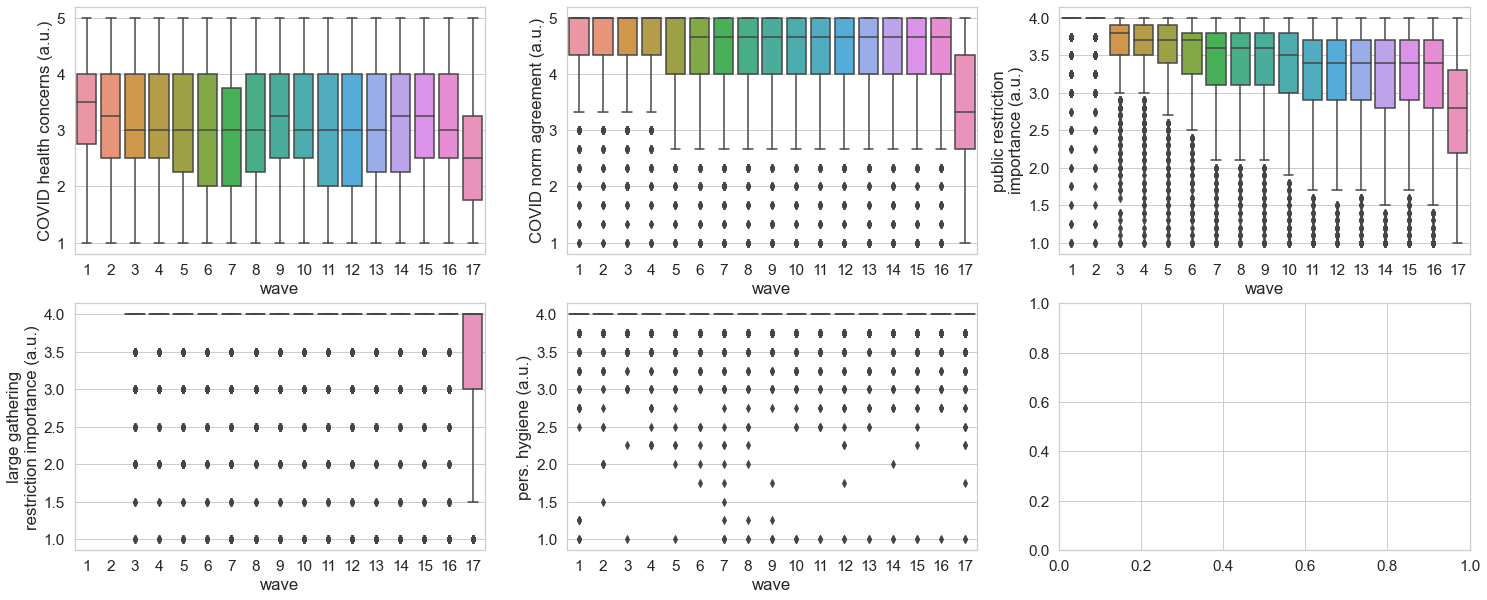

In [14]:
# within-wave variance
fig, axs = plt.subplots(2,3, figsize = (25,10))
axs_flat = axs.flatten()

y_vars = ['cvd_concern', 'cvd_norm_agreement', 'restrict_f1','restrict_f2', 'restrict_f3']
y_label = ['COVID health concerns (a.u.)', 'COVID norm agreement (a.u.)', 
           'public restriction\nimportance (a.u.)', 
           'large gathering\nrestriction importance (a.u.)', 
           'pers. hygiene (a.u.)']

for idx, y in enumerate(y_vars):
    sns.boxplot(data = summary_scores, x = 'wave', y = y, ax = axs_flat[idx])
    axs_flat[idx].set_ylabel( y_label[idx])
    
img_format = 'svg'
fig.savefig(os.path.join(fig_dir, 'attitude_within_wave_spread.' + img_format), format=img_format)

var_df= summary_scores[['cvd_concern', 'cvd_norm_agreement', 'restrict_f1','restrict_f2', 'restrict_f3','wave']].groupby(by = 'wave').var()
var_df.median()

cvd_concern           0.181920
cvd_norm_agreement    0.141865
restrict_f1           0.069328
restrict_f2           0.000000
restrict_f3           0.000000
dtype: float64

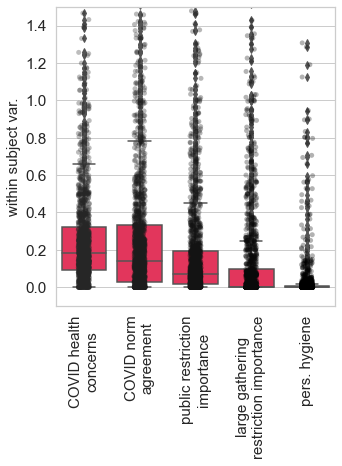

In [17]:
summary_scores_zscore = summary_scores.copy()

for y in y_vars:
    summary_scores_zscore[y_vars] = (summary_scores_zscore[y_vars] -summary_scores_zscore[y_vars].mean())/summary_scores_zscore[y_vars].std()


fig, ax = plt.subplots(1,1, figsize = (5,5.5))
x_label = ['COVID health\nconcerns', 'COVID norm\nagreement', 
           'public restriction\nimportance', 
           'large gathering\nrestriction importance', 
           'pers. hygiene']

# Within subject variance across waves per measure
sns.boxplot(summary_scores[['cvd_concern', 'cvd_norm_agreement', 'restrict_f1','restrict_f2', 'restrict_f3','PROLIFIC_PID']].groupby(by = 'PROLIFIC_PID').var(), ax = ax,
            palette = [[1,0.1,0.3]])
sns.stripplot(summary_scores[['cvd_concern', 'cvd_norm_agreement', 'restrict_f1','restrict_f2', 'restrict_f3','PROLIFIC_PID']].groupby(by = 'PROLIFIC_PID').var(), ax = ax, 
                palette='dark:black', alpha = 0.3)
ax.set_xticklabels( x_label,rotation = 90, fontsize = 15);
ax.set_ylim((-0.1,1.5));
ax.set_ylabel('within subject var.',fontsize = 15)

img_format = 'svg'
fig.savefig(os.path.join(fig_dir, 'withinSubVar_attitudes.' + img_format), format=img_format)


var_df= summary_scores[['cvd_concern', 'cvd_norm_agreement', 'restrict_f1','restrict_f2', 'restrict_f3','PROLIFIC_PID']].groupby(by = 'PROLIFIC_PID').var()
var_df.median()

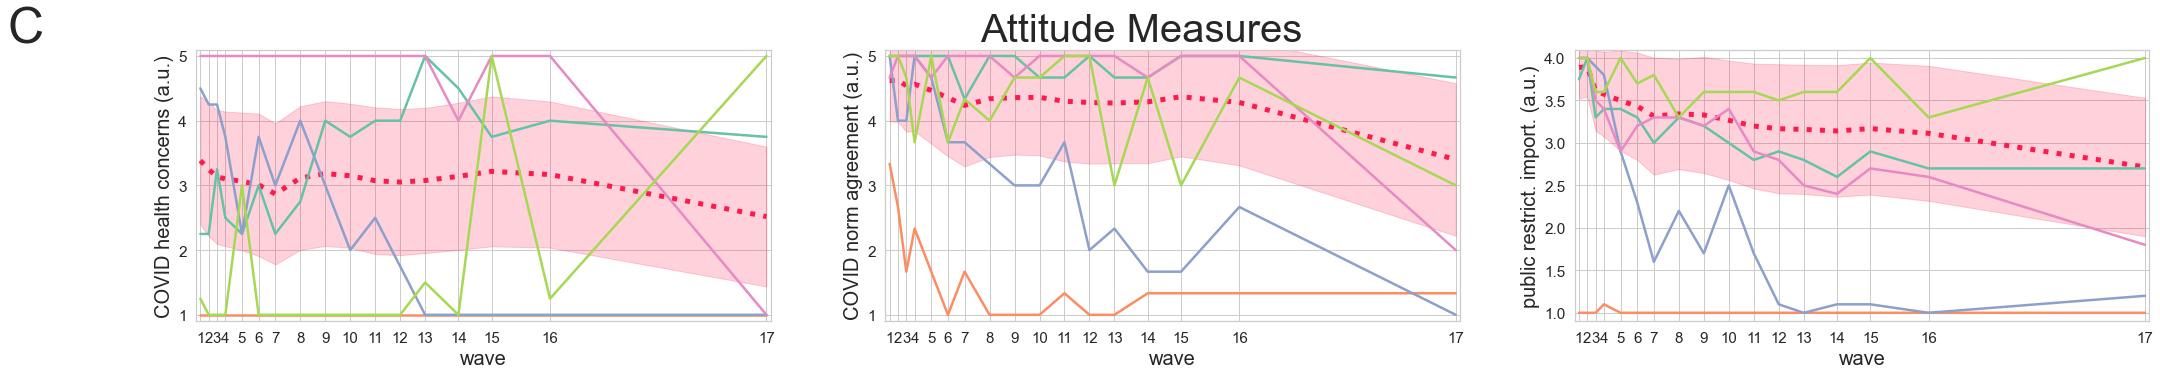

In [18]:
# visualize COVID  attitude measures
fig, axs = plt.subplots(1,3, figsize = (35,5))
fig.suptitle('Attitude Measures',  fontsize = 40)
fig.text(0.05, 1, 'C', verticalalignment='top', horizontalalignment='left',  fontsize = 50)


## cvd_concern
most_dist = max_var_concern.loc[best_sols_labels].copy()
most_dist = most_dist.T
most_dist = pd.DataFrame(most_dist.stack()).reset_index().rename(columns = {0:'value'})

sns.lineplot(data = summary_scores, x = 'week', y ='cvd_concern', color=[1,0.1,0.3], 
             linewidth=5,linestyle = ':',  ax = axs[0], errorbar=('sd')) 
sns.lineplot(data = most_dist, x = 'week', y = 'value', hue ='PROLIFIC_PID', 
             ax = axs[0], linewidth=2.5,palette = "Set2", legend=False)
axs[0].set_xticks(summary_scores.week.unique())
axs[0].set_xticklabels(summary_scores.wave.unique(), fontsize = 15)
axs[0].set_xlabel('wave',fontsize = 20)
axs[0].set_ylim([0.9,5.1])
axs[0].set_ylabel('COVID health concerns (a.u.)',fontsize = 20)
axs[0].set_xlim([0.5,69.5])


## cvd_norm_agreement
most_dist = max_var_norm.loc[best_sols_labels].copy()
most_dist = most_dist.T
most_dist = pd.DataFrame(most_dist.stack()).reset_index().rename(columns = {0:'value'})

sns.lineplot(data = summary_scores, x = 'week', y = 'cvd_norm_agreement', color=[1,0.1,0.3], 
             linewidth=5, linestyle = ':',  ax = axs[1], errorbar=('sd')) 
sns.lineplot(data = most_dist, x = 'week', y = 'value', hue ='PROLIFIC_PID', 
             ax = axs[1], linewidth=2.5,palette = "Set2", legend=False)
axs[1].set_xticks(summary_scores.week.unique()); 
axs[1].set_xticklabels(summary_scores.wave.unique(), fontsize = 15); 
axs[1].set_xlabel('wave', fontsize = 20); 
axs[1].set_ylim([0.9,5.1]); 
axs[1].set_ylabel('COVID norm agreement (a.u.)', fontsize = 20); 
axs[1].set_xlim([0.5,69.5])


## public restriction importance 
most_dist = max_var_f1.loc[best_sols_labels].copy()
most_dist = most_dist.T
most_dist = pd.DataFrame(most_dist.stack()).reset_index().rename(columns = {0:'value'})

sns.lineplot(data = summary_scores, x = 'week', y = 'restrict_f1', color=[1,0.1,0.3], 
             linewidth=5, linestyle = ':',  ax = axs[2], errorbar=('sd')) 
sns.lineplot(data = most_dist, x = 'week', y = 'value', hue ='PROLIFIC_PID', 
             ax = axs[2], linewidth=2.5,palette = "Set2", legend=False)
axs[2].set_xticks(summary_scores.week.unique()); 
axs[2].set_xticklabels(summary_scores.wave.unique(), fontsize = 15); 
axs[2].set_xlabel('wave', fontsize = 20); 
axs[2].set_ylabel('public restrict. import. (a.u.)', fontsize = 20); 
axs[2].set_ylim([0.9,4.1])
axs[2].set_xlim([0.5,69.5])


# ## large gatherings restrict. import.
# most_dist = max_var_f2.loc[best_sols_labels].copy()
# most_dist = most_dist.T
# most_dist = pd.DataFrame(most_dist.stack()).reset_index().rename(columns = {0:'value'})

# sns.lineplot(data = summary_scores, x = 'week', y = 'restrict_f2', color=[1,0.1,0.3], 
#              linewidth=5,linestyle = ':',  ax = axs[1,1], errorbar=('sd')) 
# sns.lineplot(data = most_dist, x = 'week', y = 'value', hue ='PROLIFIC_PID', 
#              ax = axs[1,1], linewidth=2.5,palette = "Set2", legend=False)
# axs[1,1].set_xticks(summary_scores.week.unique()); 
# axs[1,1].set_xticklabels(summary_scores.wave.unique(), fontsize = 15); 
# axs[1,1].set_xlabel('wave', fontsize = 20); 
# axs[1,1].set_ylabel('large gatherings\nrestrict. import. (a.u.)', fontsize = 20); 
# axs[1,1].set_ylim([0.9,4.1])
# axs[1,1].set_xlim([0.5,69.5])


# ## personal hygiene import.
# most_dist = max_var_f3.loc[best_sols_labels].copy()
# most_dist = most_dist.T
# most_dist = pd.DataFrame(most_dist.stack()).reset_index().rename(columns = {0:'value'})

# sns.lineplot(data = summary_scores, x = 'week', y = 'restrict_f3', color=[1,0.1,0.3], 
#              linewidth=5, linestyle = ':',  ax = axs[1,2], errorbar=('pi')) 
# sns.lineplot(data = most_dist, x = 'week', y = 'value', hue ='PROLIFIC_PID', 
#              ax = axs[1,2], linewidth=2.5,palette = "Set2", legend=False)
# axs[1,2].set_xticks(summary_scores.week.unique()); 
# axs[1,2].set_xticklabels(summary_scores.wave.unique(), fontsize = 15); 
# axs[1,2].set_xlabel('wave', fontsize = 20); 
# axs[1,2].set_ylabel('personal hygiene\nimport. (a.u.)',  fontsize = 20); 
# axs[1,2].set_ylim([0.9,4.1])
# axs[1,2].set_xlim([0.5,69.5])


img_format = 'svg'
fig.savefig(os.path.join(fig_dir, 'timecourse_CVD_attitudes.' + img_format), format=img_format)
    

# Personal Experience Measures

In [19]:
# SOCIAL NETWORK HEALTH IMPACT
def health_impact(col_nameV1,col_nameV2,  soc_cat, data, out_data):
    '''
    Health impact in the social network was assesed in two differnt variables (w1-8: RW21; w9-18: RW21v2)
    This function combines the two variabales and creates a summary score for the defined social category.
    @ Input:
    col_nameV1 (string): V1 data column, e.g. "RW21_1" --> spouse
    col_nameV2 (string): V2 data column, e.g. "RW21v2_1" --> spouse
    soc_cat (string): label for social category, e.g. "spouse_health_impact"
    data (df): all data dataframe
    out_data (df): summary output dataframe
    '''
    
    tmp_cols = []
    for idx in range(2,6):
        tmp_cols.append(col_nameV1 + '_' + str(idx))
        tmp_cols.append(col_nameV2 + '_' + str(idx))

    tmp_cols = ['PROLIFIC_PID', 'wave'] + tmp_cols
    tmp_data = data[tmp_cols].copy()  

    tmp_data_w1_8 = tmp_data.columns[(tmp_data.columns.str.startswith('RW21_')) & (~tmp_data.columns.str.endswith('1'))]
    tmp_data_w9_18 = tmp_data.columns[(tmp_data.columns.str.startswith('RW21v2_'))& (~tmp_data.columns.str.endswith('1'))]


    tmp_data = tmp_data.fillna(0)
    for idx, col in enumerate(tmp_data_w1_8):
         tmp_data.loc[tmp_data[col] == '1.0', col] = idx+1
    for idx, col in enumerate(tmp_data_w9_18):
         tmp_data.loc[tmp_data[col] == '1.0', col] = idx+1        
    out_data[soc_cat] = tmp_data.iloc[:,2:].max(axis=1)
    return out_data

summary_scores = health_impact('RW21_1' ,'RW21v2_1',  'spouse_health_impact', data, summary_scores)
summary_scores = health_impact('RW21_2' ,'RW21v2_2',  'parent_health_impact', data, summary_scores)
summary_scores = health_impact('RW21_3' ,'RW21v2_3',  'grandparent_health_impact', data, summary_scores)
summary_scores = health_impact('RW21_4' ,'RW21v2_4',  'thirdDegree_health_impact', data, summary_scores)
summary_scores = health_impact('RW21_5' ,'RW21v2_5',  'child_health_impact', data, summary_scores)
summary_scores = health_impact('RW21_6' ,'RW21v2_6',  'friend_health_impact', data, summary_scores)
summary_scores = health_impact('RW21_7' ,'RW21v2_7',  'work_colleague_health_impact', data, summary_scores)
summary_scores = health_impact('RW21_9' ,'RW21v2_9',  'sibling_health_impact', data, summary_scores)


tmp_data = summary_scores[['PROLIFIC_PID','week','wave',
                           'spouse_health_impact', 
                           'parent_health_impact', 
                           'grandparent_health_impact',
                           'thirdDegree_health_impact', 
                           'child_health_impact', 
                           'friend_health_impact',
                           'work_colleague_health_impact',
                           'sibling_health_impact']].melt(id_vars=['PROLIFIC_PID',
                                                                  'week', 
                                                                  'wave'], value_vars=['spouse_health_impact', 
                                                                                       'parent_health_impact',
                                                                                       'grandparent_health_impact',
                                                                                       'thirdDegree_health_impact', 
                                                                                       'child_health_impact', 
                                                                                       'friend_health_impact',
                                                                                       'work_colleague_health_impact',
                                                                                       'sibling_health_impact'])

# summarize social network health impact 
summary_scores.loc[:,'mean_social_network_health'] = summary_scores[['spouse_health_impact', 'parent_health_impact',
                                                 'grandparent_health_impact','sibling_health_impact', 
                                                 'thirdDegree_health_impact','child_health_impact', 
                                                 'friend_health_impact','work_colleague_health_impact']].max(axis=1)

In [20]:
# reshape COVID experience measures for maximum variation sampling 

max_var_safety_measures = summary_scores.loc[:,['PROLIFIC_PID', 'week','wave','safety_measures']]
max_var_safety_measures = max_var_safety_measures.pivot(index = 'PROLIFIC_PID', columns = ['week'], values = 'safety_measures')
max_var_safety_measures = max_var_safety_measures.dropna(axis = 0)

max_var_weekly_income = summary_scores.loc[:,['PROLIFIC_PID', 'week','weekly_income_self_cat_num']]
max_var_weekly_income = max_var_weekly_income.pivot(index = 'PROLIFIC_PID', columns = ['week'], values = 'weekly_income_self_cat_num')
max_var_weekly_income = max_var_weekly_income.dropna(axis = 0)

max_var_mean_social_network_health = summary_scores.loc[:,['PROLIFIC_PID', 'week','mean_social_network_health']]
max_var_mean_social_network_health = max_var_mean_social_network_health.pivot(index = 'PROLIFIC_PID', columns = ['week'], values = 'mean_social_network_health')
max_var_mean_social_network_health = max_var_mean_social_network_health.dropna(axis = 0)

K = 5
value_array = max_var_safety_measures.values
id_lables = max_var_safety_measures.index
best_sols_feats, best_sols_labels = max_var_sampling(value_array, id_lables, K)
most_dist = max_var_safety_measures.loc[best_sols_labels].copy()
most_dist = most_dist.T
most_dist = pd.DataFrame(most_dist.stack()).reset_index().rename(columns = {0:'value'})



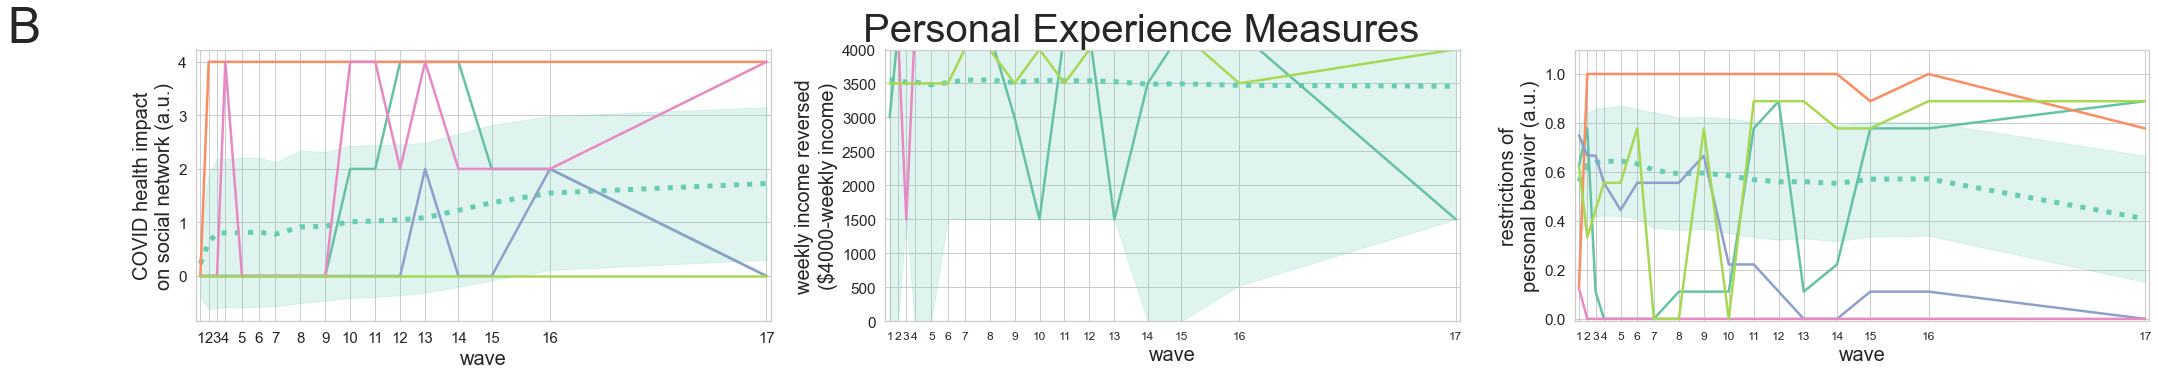

In [21]:
# visualize COVID  experience measures
fig, axs = plt.subplots(1,3, figsize = (35,5))
fig.suptitle('Personal Experience Measures',  fontsize = 40)
fig.text(0.05, 1, 'B', verticalalignment='top', horizontalalignment='left',  fontsize = 50)


## mean social network health 
most_dist = max_var_mean_social_network_health.loc[best_sols_labels].copy()
most_dist = most_dist.T
most_dist = pd.DataFrame(most_dist.stack()).reset_index().rename(columns = {0:'value'})

sns.lineplot(data = summary_scores, x ='week',  y = 'mean_social_network_health', color=[0.4,0.8,0.7], 
             linewidth=5, linestyle = ':',  ax = axs[0], errorbar=('sd')) 
sns.lineplot(data = most_dist, x = 'week', y = 'value', hue ='PROLIFIC_PID', 
             ax = axs[0], linewidth=2.5,palette = "Set2", legend=False)
axs[0].set_xticks(summary_scores.week.unique());
axs[0].set_xticklabels(summary_scores.wave.unique(), fontsize = 15);
axs[0].set_xlabel('wave', fontsize = 20)
axs[0].set_xlim([0.5,69.5])
axs[2].set_ylim([-0.01,4.1])
axs[0].set_ylabel('COVID health impact\non social network (a.u.)', fontsize = 20)
handles, labels = axs[2].get_legend_handles_labels()



## personal weekly income
most_dist = max_var_weekly_income.loc[best_sols_labels].copy()
most_dist = most_dist.T
most_dist = pd.DataFrame(most_dist.stack()).reset_index().rename(columns = {0:'value'})
# reverse income for plotting
most_dist['value'] = summary_scores.weekly_income_self_cat_num.max()+1 - most_dist['value']
summary_scores['weekly_income_self_cat_num_reverse'] = summary_scores.weekly_income_self_cat_num.max()+1 -summary_scores.weekly_income_self_cat_num

sns.lineplot(data = summary_scores, x = 'week', y = 'weekly_income_self_cat_num_reverse', color=[0.4,0.8,0.7], 
             linewidth=5, linestyle = ':',  ax = axs[1], errorbar=('pi')) 
sns.lineplot(data = most_dist, x = 'week', y = 'value', hue ='PROLIFIC_PID', 
             ax = axs[1], linewidth=2.5,palette = "Set2", legend=False)
axs[1].set_xticks(summary_scores.week.unique());
axs[1].set_xticklabels(summary_scores.wave.unique(), fontsize = 15);
axs[1].set_xlabel('wave', fontsize = 20)
axs[1].set_xlim([0.5,69.5])
axs[1].set_ylabel('weekly income reversed\n($4000-weekly income)', fontsize = 20);
axs[1].tick_params(axis='x', labelsize=12)
axs[1].set_ylim([0,4000])


## safety measures adopted
most_dist = max_var_safety_measures.loc[best_sols_labels].copy()
most_dist = most_dist.T
most_dist = pd.DataFrame(most_dist.stack()).reset_index().rename(columns = {0:'value'})

sns.lineplot(data = summary_scores, x = 'week', y = 'safety_measures', color=[0.4,0.8,0.7], 
             linewidth=5, linestyle = ':',  ax = axs[2], errorbar=('sd')) 
sns.lineplot(data = most_dist, x = 'week', y = 'value', hue ='PROLIFIC_PID', 
             ax = axs[2], linewidth=2.5,palette = "Set2", legend=False)
axs[2].set_xticks(summary_scores.week.unique());
axs[2].set_xticklabels(summary_scores.wave.unique(), fontsize = 15);
axs[2].set_xlabel('wave', fontsize = 20)
axs[2].set_xlim([0.5,69.5])
axs[2].set_ylabel('restrictions of\npersonal behavior (a.u.)', fontsize = 20);
axs[2].set_ylim([-0.01,1.1])
axs[2].tick_params(axis='x', labelsize=12)
axs[2].yaxis.label.set_size(20)
axs[2].xaxis.label.set_size(20)


img_format = 'svg'
fig.savefig(os.path.join(fig_dir, 'timecourse_CVD_impact.' + img_format), format=img_format)
    

In [22]:
# save summary scores
summary_scores.to_csv(os.path.join(out_dir, 'CVD_core_summary_scores.csv'), index = False)